In [1]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import numpy
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list is a list of my selected features
# all_features is a list for exploration
#features_list = ['poi', 'bonus', 'expenses', 'bon_plus_expenses', 'bon_sal_ratio', \
#                'to_msg_ratio', 'from_msg_ratio']

features_list = ['poi', 'bon_plus_expenses', 'exercised_stock_options', 
                'total_payments']
all_features = ['poi', 'salary', 'bonus', 'long_term_incentive', \
                'deferred_income', 'expenses', 'total_payments', \
                'exercised_stock_options', 'restricted_stock', 'other', 'to_messages', \
                'email_address', 'from_poi_to_this_person', 'from_messages', \
                'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_msg_ratio', \
                'from_msg_ratio', 'bon_plus_expenses', 'bon_sal_ratio'] 


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)

In [3]:
# Find how many missing values are in all features
for feature in all_features:
    try:
        print "Number of missing values in " + str(feature) + ": " + str(df[feature].value_counts(dropna=False)[0])
    except:
        print "Created feature: ", str(feature)

Number of missing values in poi: 128
Number of missing values in salary: 51
Number of missing values in bonus: 64
Number of missing values in long_term_incentive: 80
Number of missing values in deferred_income: 97
Number of missing values in expenses: 51
Number of missing values in total_payments: 21
Number of missing values in exercised_stock_options: 44
Number of missing values in restricted_stock: 36
Number of missing values in other: 53
Number of missing values in to_messages: 60
Number of missing values in email_address: 35
Number of missing values in from_poi_to_this_person: 12
Number of missing values in from_messages: 60
Number of missing values in from_this_person_to_poi: 20
Number of missing values in shared_receipt_with_poi: 60
Created feature:  to_msg_ratio
Created feature:  from_msg_ratio
Created feature:  bon_plus_expenses
Created feature:  bon_sal_ratio


In [4]:
# Create another working dataframe to make new features 
df_new = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).copy()

In [5]:
# from_msg_ratio is ratio messages received from poi to total messages received
df_new['to_msg_ratio'] = df_new.from_this_person_to_poi.divide(df_new.to_messages, axis = 'index')

# create to_msg_ratio by dividing from_this_person_to_poi from to_messages
df_new['from_msg_ratio'] = df_new.from_poi_to_this_person.divide(df_new.from_messages, axis = 'index')

# create a new feature by adding expenses and bonus together
df_new['bon_plus_expenses'] = df_new['bonus'].add(df_new['expenses'], axis = 'index')
# new feature of bonus to salary ratio

df_new['bon_sal_ratio'] = df_new['bonus'].divide(df_new['salary'], axis = 'index')
# new feature of bonus to expenses ratio

In [6]:
# Fill NaN with 0 where operations created NaN in some rows
df_new.fillna(0, inplace = True)

In [7]:
# after you create features, the column names will be your new features
# create a list of column names:
new_features_list = df_new.columns.values
new_features_list

array(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'loan_advances', 'long_term_incentive',
       'other', 'poi', 'restricted_stock', 'restricted_stock_deferred',
       'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value', 'to_msg_ratio',
       'from_msg_ratio', 'bon_plus_expenses', 'bon_sal_ratio'], dtype=object)

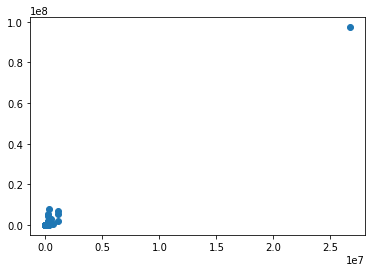

In [8]:
### Task 2: Remove outliers

# plot salary vs bonus as first step of outlier detection, visually

%matplotlib inline

x = df_new['salary']
y = df_new['bonus']

plt.scatter(x, y)

In [9]:
print "Highest bonus value: " + str(df_new['bonus'].max())
print "Highest salary value: " + str(df_new['salary'].max())

Highest bonus value: 97343619.0
Highest salary value: 26704229.0


In [10]:
df_new.sort_values(['bonus', 'salary'], ascending=False)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_msg_ratio,from_msg_ratio,bon_plus_expenses,bon_sal_ratio
TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,0.0,311764000.0,5235198.0,0.0,0.0,0.0,...,-7576788.0,26704229.0,0.0,0.0,309886585.0,434509511.0,0.000000,0.000000,102578817.0,3.645251
LAVORATO JOHN J,8000000.0,0.0,0.0,0.0,0.0,4158995.0,49537.0,2585.0,528.0,411.0,...,0.0,339288.0,3962.0,7259.0,10425757.0,5167144.0,0.056619,0.204255,8049537.0,23.578789
LAY KENNETH L,7000000.0,202911.0,-300000.0,0.0,0.0,34348384.0,99832.0,36.0,123.0,16.0,...,0.0,1072321.0,2411.0,4273.0,103559793.0,49110078.0,0.003744,3.416667,7099832.0,6.527896
SKILLING JEFFREY K,5600000.0,0.0,0.0,0.0,0.0,19250000.0,29336.0,108.0,88.0,30.0,...,0.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0,0.008271,0.814815,5629336.0,5.039334
BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,0.0,0.0,953136.0,17355.0,484.0,228.0,108.0,...,0.0,213999.0,5521.0,7991.0,5501630.0,1110705.0,0.013515,0.471074,5267354.0,24.532820
ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,...,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0,0.022398,0.021412,4188868.0,20.672922
KITCHEN LOUISE,3100000.0,0.0,0.0,0.0,0.0,81042.0,5774.0,1728.0,251.0,194.0,...,0.0,271442.0,3669.0,8305.0,3471141.0,547143.0,0.023359,0.145255,3105774.0,11.420488
WHALLEY LAWRENCE G,3000000.0,0.0,0.0,0.0,0.0,3282960.0,57838.0,556.0,186.0,24.0,...,0.0,510364.0,3920.0,6019.0,4677574.0,6079137.0,0.003987,0.334532,3057838.0,5.878158
DELAINEY DAVID W,3000000.0,0.0,0.0,0.0,0.0,2291113.0,86174.0,3069.0,66.0,609.0,...,0.0,365163.0,2097.0,3093.0,4747979.0,3614261.0,0.196896,0.021505,3086174.0,8.215509
MCMAHON JEFFREY,2600000.0,0.0,0.0,0.0,0.0,1104054.0,137108.0,48.0,58.0,26.0,...,0.0,370448.0,2228.0,2355.0,4099771.0,1662855.0,0.011040,1.208333,2737108.0,7.018529


In [11]:
# Remove row "TOTAL" because it's not a proper data point, as in it's not an employee
df_new.drop(['TOTAL'], inplace=True)

In [12]:
# Once outliers are removed, data values should be scaled
# Email ratios definitely don't match bonus and expenses scales
df_new_scaled = (df_new- df_new.min()) / (df_new.max() - df_new.min())
# Some of these may have created NaNs in the dataset
# Fill the NaN with 0 again
df_new_scaled.fillna(0, inplace = True)

In [13]:
# create a dictionary from the dataframe
df_dict = df_new_scaled.to_dict('index')

In [14]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df_dict

In [15]:
len(my_dataset)

145

In [16]:
### Extract features and labels from dataset for local testing
# Created one function for exploration then another for use after feature selection
exploration_data = featureFormat(my_dataset, all_features, sort_keys = True)
labels_exploration, features_exploration = targetFeatureSplit(exploration_data)

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [17]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

In [18]:
# First one tried is RandomForestClassifier
rfc_exploration = RandomForestClassifier()
rfc_exploration = rfc_exploration.fit(features_exploration, labels_exploration)

In [19]:
# Also trying a decision tree classifier because tree classifiers make sense here
dc_exploration = DecisionTreeClassifier()
dc_exploration= dc_exploration.fit(features_exploration, labels_exploration)

In [20]:
# This function appends the feature and according importance value from tree
# classifier to a list to view more neatly
rfc_impt = []
dc_impt = []

def input_impt(impt_list, features_list, impts):
    for i in range(len(impts)):
        impt_list.append( (features_list[i], impts[i]) )
    
    impt_list.sort(key = lambda tup: tup[1], reverse = True)
    
    return impt_list

In [21]:
# Call previous function to append and sort feature importances 
input_impt(rfc_impt, all_features[1:], rfc_exploration.feature_importances_)
input_impt(dc_impt, all_features[1:], dc_exploration.feature_importances_)

[('bon_plus_expenses', 0.29502004557122657),
 ('expenses', 0.17125124189984753),
 ('restricted_stock', 0.12049154306372167),
 ('exercised_stock_options', 0.1178661654327829),
 ('total_payments', 0.091078358794894232),
 ('from_poi_to_this_person', 0.084572761738116065),
 ('bonus', 0.054368203974503197),
 ('to_messages', 0.042286380869058032),
 ('to_msg_ratio', 0.023065298655849813),
 ('salary', 0.0),
 ('long_term_incentive', 0.0),
 ('deferred_income', 0.0),
 ('other', 0.0),
 ('email_address', 0.0),
 ('from_messages', 0.0),
 ('from_this_person_to_poi', 0.0),
 ('shared_receipt_with_poi', 0.0),
 ('from_msg_ratio', 0.0),
 ('bon_sal_ratio', 0.0)]

In [22]:
print "RandomForestClassifier importances values: "
for item in rfc_impt:
    print item[0] + " : " + str(item[1])

RandomForestClassifier importances values: 
bonus : 0.174305544413
long_term_incentive : 0.101105968199
exercised_stock_options : 0.0850667372746
expenses : 0.0846575574768
bon_sal_ratio : 0.0714016527855
from_msg_ratio : 0.0618470479258
restricted_stock : 0.0616582627631
other : 0.0528789175658
bon_plus_expenses : 0.0528202577138
deferred_income : 0.0512402586401
salary : 0.0372295163388
shared_receipt_with_poi : 0.0350578743326
to_msg_ratio : 0.0272094809182
total_payments : 0.0260644531305
to_messages : 0.0249720275401
from_poi_to_this_person : 0.0238494817865
from_this_person_to_poi : 0.0161897317943
from_messages : 0.0124452294015
email_address : 0.0


In [23]:
print "DecisionTreeClassifier importances values: "
for item in dc_impt:
    print item[0] + " : " + str(item[1])

DecisionTreeClassifier importances values: 
bon_plus_expenses : 0.295020045571
expenses : 0.1712512419
restricted_stock : 0.120491543064
exercised_stock_options : 0.117866165433
total_payments : 0.0910783587949
from_poi_to_this_person : 0.0845727617381
bonus : 0.0543682039745
to_messages : 0.0422863808691
to_msg_ratio : 0.0230652986558
salary : 0.0
long_term_incentive : 0.0
deferred_income : 0.0
other : 0.0
email_address : 0.0
from_messages : 0.0
from_this_person_to_poi : 0.0
shared_receipt_with_poi : 0.0
from_msg_ratio : 0.0
bon_sal_ratio : 0.0


In [24]:
# Assign to new classifiers after choosing features

rfc = rfc_exploration.fit(features, labels)
dc = dc_exploration.fit(features, labels)

In [25]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [26]:
# straified cv for parameters, 100 fold, and shuffled
best_cv = StratifiedShuffleSplit(n_splits = 100, random_state=42) 

In [ ]:
# random_state is to bring consistency to results
# results to best_params_ were inconsistent before adding random_state
# If you uncomment to run these lines of code, it may take a while.
# Added start and end times to see how long this all takes because
# this exhaustive method has been taking forever. 
# Both CV settings are set to optimize for f1 to get better precision and recall
# It took me 78 minutes to run rfc and about 3 to run decisiontreeclassifier

#start_gridcv_rfc = time.time()
#rfc_param_grid = {'n_estimators': [1,2, 3, 10, 100], 
#                 'min_samples_split': [2, 3, 5],
#                 'random_state': [2],
#                 'max_features': [1, 2, 3],
#                 'max_depth' : [2, 3, 5, 10, 50],
#                 'min_samples_leaf': [1, 2, 3, 10]
#                 }

#grid_cv_rfc = GridSearchCV(estimator = rfc, param_grid = rfc_param_grid, cv = best_cv,
#                          n_jobs = 5, scoring = 'f1')
#grid_cv_rfc.fit(features, labels)
#end_gridcv_rfc = time.time()
#print "Minutes elapsed: " + str((float(end_gridcv_rfc - start_gridcv_rfc) / 60))

In [ ]:
# gridsearchcv for decisiontreeclassifier
# The list comprehension for max_features is just to make the feature selection
# process easier on me.

start_gridcv_dc = time.time()
dc_param_grid = {'min_samples_split' : [2, 3, 4, 5, 10, 50],
                 'max_features' : [x for x in range(1, len(features_list))],
                 'min_samples_leaf': [1, 2, 3, 10, 20],
                'random_state' : [2]
                }
grid_cv_dc = GridSearchCV(estimator = dc, param_grid = dc_param_grid, cv = best_cv,
                         n_jobs = 5, scoring = 'f1')
grid_cv_dc.fit(features, labels)
end_gridcv_dc = time.time()
print "Minutes elapsed: " + str((float(end_gridcv_dc - start_gridcv_dc) / 60))

/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metric

In [ ]:
#print classification_report(labels_train, grid_cv_rfc.best_estimator_.predict(features_train))

In [ ]:
print classification_report(labels_train, grid_cv_dc.best_estimator_.predict(features_train))

In [ ]:
#print classification_report(labels_test, grid_cv_rfc.best_estimator_.predict(features_test))

In [ ]:
print classification_report(labels_test, grid_cv_dc.best_estimator_.predict(features_test))

In [ ]:
#grid_cv_rfc.best_params_

In [ ]:
# Assign clf to classifer chosen after testing with tester.py
# Parameters are selected from GridSearchCV's best_params_ attributes

#clf = RandomForestClassifier(min_samples_split = 5, n_estimators = 3,
#                            random_state = 2, max_depth = 50, min_samples_leaf = 1,
#                            max_features = 1)
#clf.fit(features, labels)

In [ ]:
grid_cv_dc.best_params_

In [ ]:
# Parameters are selected from GridSearchCV's best_params_ attributes
# I ended up choosing DecisionTreeClassifier because it performed better with
# precision and recall in tester.py
clf = DecisionTreeClassifier(min_samples_split = 2, random_state = 2,
                            max_features = 3, min_samples_leaf = 1)
clf.fit(features, labels)

In [ ]:
labels_pred = clf.predict(features_test)
f1_score(labels_test, labels_pred)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
